#**Subtask A - Conspiratorial Content Classification**

#**Gruppo: Tris di Token**
Componenti: Barca Antonio, Bongiorno Rosario,
Giambanco Alessandro

#Librerie

In [1]:
!pip install emoji
!pip install transformers
!pip install accelerate -U
!pip install googletrans==3.1.0a0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=b22cb3565f57e3dace61f053cc3412dc170b5d200373956ad8e0004df0eeb6d6
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1

In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import nltk
import re
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm
import emoji
from torch import nn
from torch.optim import Adam
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from googletrans import Translator

#Dati iniziali

In [5]:
drive.mount('/content/gdrive')
root = "/content/gdrive/MyDrive/Tris di token/dataset/"

Mounted at /content/gdrive


Caricamento dataset

In [6]:
df=pd.read_csv(root+"subtaskA_train.csv")

#Data augmentation

Per effettuare l'aumento di dati, abbiamo deciso di implementare una doppia traduzione dei dati. In particolare una prima traduzione da Italiano a Tedesco, ed una seconda da Tedesco a Italiano. La scelta della lingua tedesca è stata decisa per ottenere una migliore differenziazione delle parole tradotte e ritradotte.

Inizialmente abbiamo effettuato uno split del dataset originale per evitare che nel validation set si possano presentare 'comment_text' molto simili a quelli presenti nel training set che possono rendere non attendibili i dati di accuracy, loss e f1-score.

In [14]:
df_train, df_val = train_test_split(df, test_size=0.20,random_state=24)

In [ ]:
# Funzione per tradurre una colonna da tedesco a italiano
def translate_to_italian(text):
    translator = Translator()
    translation = translator.translate(text, src='de', dest='it')
    return translation.text

# Funzione per tradurre una colonna da italiano a tedesco
def translate_to_german(text):
    translator = Translator()
    translation = translator.translate(text, src='it', dest='de')
    return translation.text

La funzione 'aggiungi_elementi' utilizza le due funzioni precedenti per la traduzione passandogli in input il dataset originale 'df' ed una percentuale 'p' per prelevare quelle parti del dataset che dovranno poi essere utilizzate per la traduzione.

In [ ]:
def aggiungi_elementi(df, p):
  # crea un dataframe vuoto
  df_new = pd.DataFrame()
  # estrai una frazione p di elementi casuali dal dataframe originale
  df_sample = df.sample(frac=p)
  display(df_sample)
   # applica la funzione augmentation al dataframe campione
  df_sample['comment_text']=df_sample['comment_text'].apply(translate_to_german).apply(translate_to_italian)
   # aggiungi il dataframe con i commenti tradotti al dataframe vuoto
  df_new = df.append(df_sample)
  # restituisci il dataframe finale
  return df_new

In [ ]:
df_train_new = aggiungi_elementi(df_train, 0.30)

Salvataggio dei dataset aumentati

In [ ]:
df_train_new.to_csv(root+"subtaskA_train_30augmentation.csv", index=False)
df_val.to_csv(root+"subtaskA_val_30augmentation.csv", index=False)

#Pre-processing

Caricamento dei dataset aumentati per train set e validation set

In [15]:
df_train = pd.read_csv(root+"subtaskA_train_30augmentation.csv")
df_val = pd.read_csv(root+"subtaskA_val_30augmentation.csv")

Dopo aver esaminato il dataset, per il pre-processing abbiamo deciso di rimuovere tutti i testi tra parentesi, analizzare tutte le emoji e i caratteri UPPER-CASE presenti nel dataset per capire quali di essi contenevano informazioni rilevanti al fine della classificazione.  

In [18]:
def rimuovi_parentesi(testo): #Funzione per rimuovere i testi tra parentesi tonde all'interno del dataset
    pattern_parentesi = re.compile(r'\([^)]*\)')
    testo_senza_parentesi = pattern_parentesi.sub('', testo)
    return testo_senza_parentesi

ANALISI EMOJI  
A seguito alcune funzioni:

In [19]:
def trova_emoji(testo): #Funzione per trovare e tradurre emoji tramite la libreria 'emoji' nei singoli testi, tornando la lista delle emoji trovate
    testo_demojizzato = emoji.demojize(testo,delimiters=(" :",": "), language='it')
    emoji_trovate = estrai_tra_due_punti(testo_demojizzato)
    return emoji_trovate

def estrai_tra_due_punti(frase): #Funzione per trovare le emoji demojizzate
    risultati = re.findall(r'(:\S*?:)', frase) # Espressione regolare per catturare il testo tra due "due punti", compresi anch'essi, senza spazi all'interno
    return risultati

def analisi_emoji(df):

  df['emojis'] = df['comment_text'].apply(trova_emoji) # Aggiungi una colonna con le emoji presenti in ciascun commento

  db_emoji = pd.DataFrame() # Creazione tabella di emoji trovate

  db_emoji['Emoji'] = pd.Series(df['emojis'].explode().unique()) # Creazione della colonna 'Emoji' con tutte le emoji uniche

  db_emoji['Conspiratorial'] = db_emoji['Emoji'].apply(lambda x: df[df['conspiratorial'] == 1]['emojis'].apply(lambda y: x in y).sum()) # Conteggio delle emoji in contesto 'Conspiratorial'

  db_emoji['No-Conspiratorial'] = db_emoji['Emoji'].apply(lambda x: df[df['conspiratorial'] == 0]['emojis'].apply(lambda y: x in y).sum()) # Conteggio delle emoji in contesto 'No-Conspiratorial'

  db_emoji['Total'] = db_emoji['Conspiratorial'] + db_emoji['No-Conspiratorial'] #Conteggio totale delle emoji in entrambi i contesti

  db_emoji = db_emoji.sort_values(by='Total', ascending=False) # Ordina il DataFrame in base alla colonna 'Total' in senso decrescente

  #Inseriamo la colonna 'rilevanti' dove in base ad una soglia scelta (0.40) stabiliamo quali emoji portano informazioni significative

  db_emoji["rilevanti"]= ((abs(db_emoji['Conspiratorial'] - db_emoji['No-Conspiratorial'])) >= 0.40 * db_emoji['Total'])

  db_emoji.loc[db_emoji['Total'] <9, 'rilevanti'] = False #Se l'emoji compare in meno di 9 testi, su un dataset di 1915 testi, stabiliamo che queste emoji non sono rilevanti

  '''Spiegazione più in là
  db_emoji['Flag']= db_emoji.apply(lambda row: '1' if row['Conspiratorial'] > row['No-Conspiratorial'] else '0', axis=1)'''

  return db_emoji

def elimina_emoji(text,db_emoji): #Funzione per eliminare quelle emoji dai testi che dalla tabella 'db_emoji' non risultino rilevanti

  count_cosp=0
  count_nocosp=0

  for parola in text.split():

    if parola in db_emoji['Emoji'].tolist():

      if db_emoji.query(f"Emoji=='{parola}'")["rilevanti"].tolist()[0]==False:
        text=text.replace(parola, " ")
      """
      else:
        if db_emoji.query(f"Emoji=='{parola}'")["Flag"].tolist()[0]==str(1):
          text=text.replace(parola, " ")
          if count_cosp==1:
            break
          text = text + " CONSPIRATORIA"
          count_cosp=1
        else:
          text=text.replace(parola, " ")
          if count_nocosp==1:
            break
          text = text + " NORMALE"
          count_nocosp=1

          In questa parte di codice, avevamo deciso di non  rimpiazzare le emoji con delle parole alla fine della frase in base
          alla loro categoria di rilevanza. Nonostante ciò, effettuando l'addestramento, abbiamo notato che l'aggiunta di queste parole peggiorava i risultati rispetto
          alla sola rimozione"""

  return text

Creazione delle tabella delle emoji

In [20]:
db_emoji=analisi_emoji(df_train)

display(db_emoji)

,Emoji,Conspiratorial,No-Conspiratorial,Total,rilevanti
2,:bandiera_italia:,169,99,268,False
10,:libri:,44,38,82,False
3,:freccia_rivolta_verso_destra_che_punta_in_alto:,1,73,74,True
14,:punto_esclamativo_rosso:,49,20,69,True
7,:pagina:,30,33,63,False
...,...,...,...,...,...
89,:stella:,0,1,1,False
59,:segnale_di_stop:,0,1,1,False
58,:aeroplano:,0,1,1,False
119,:faccina_stordita:,1,0,1,False


ANALISI UPPER CASE

In [21]:
def analisi_upper(df):
  df_maiusc = pd.DataFrame(index=['Commenti con carattere maiuscolo presente almeno nel 60% della frase',
                                 'Commenti con carattere maiuscolo presente meno nel 60% della frase'],
                          columns=['Conspiratorial', 'No-Conspiratorial'])

  # Calcolo del numero di caratteri maiuscoli nelle frasi
  df['Upper_Count'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper())) #Conteggio parole maiuscole per frase
  df['Total_Count'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c.isalpha())) #Conteggio totale parole per frase

  # Soglia del 60% del totale
  threshold = 0.6

  # Creazione delle condizioni per le due categorie di commenti
  uppercase_condition = df['Upper_Count'] >= threshold * df['Total_Count'] #Se i valori maiuscoli sono maggiori del totale rispetto alla soglia allora restituirà True

  #Applicazione della condizione con conteggio
  df_maiusc.loc['Commenti con carattere maiuscolo presente almeno nel 60% della frase', 'Conspiratorial'] = df[(uppercase_condition) & (df['conspiratorial'] == 1)].shape[0]
  df_maiusc.loc['Commenti con carattere maiuscolo presente meno nel 60% della frase', 'Conspiratorial'] = df[(~uppercase_condition) & (df['conspiratorial'] == 1)].shape[0]
  df_maiusc.loc['Commenti con carattere maiuscolo presente almeno nel 60% della frase', 'No-Conspiratorial'] = df[(uppercase_condition) & (df['conspiratorial'] == 0)].shape[0]
  df_maiusc.loc['Commenti con carattere maiuscolo presente meno nel 60% della frase', 'No-Conspiratorial'] = df[(~uppercase_condition) & (df['conspiratorial'] == 0)].shape[0]

  return df_maiusc

Creazione della tabella per gli UPPER-CASE

In [22]:
df_maiusc=analisi_upper(df_train)

display(df_maiusc)

,Conspiratorial,No-Conspiratorial
Commenti con carattere maiuscolo presente almeno nel 60% della frase,12,8
Commenti con carattere maiuscolo presente meno nel 60% della frase,946,949


Dopo aver esaminato le due tabelle, abbiamo constatato che:  

1) Dalla tabella delle emoji, si evince che alcune emoji risultano abbastanza significative per la classificazione in quanto esse compaiono in maniera predominante in una classe rispetto all'altra; pertanto abbiamo deciso di eliminare tutte quelle emoji che non risultavano rilevanti dal dataset lasciando esclusivamente quelle che lo sono.    

2) Dalla tabella degli UPPER-CASE, si evince che le parole maiuscolo sono distribuite in maniera uniforme in entrambe le classi, quindi non contengono informazioni rilevanti (sia per la soglia scelta del 60% che per soglie minori fino al 20 %); pertanto abbiamo deciso di non apportare alcuna modifica.

Pre-processing per train e validation

In [17]:
def preprocessing(df, db_emoji):

  df['comment_text'] = df['comment_text'].apply(rimuovi_parentesi)
  df['comment_text'] = df['comment_text'].str.replace('\n', ' ')

  df['comment_text'] = df['comment_text'].apply(lambda x:emoji.demojize(x,delimiters=(" :",": "),language='it'))

  df['comment_text'] = df['comment_text'].apply(lambda x:elimina_emoji(x,db_emoji))

  return df

In [23]:
df_train=preprocessing(df_train, db_emoji)
df_val=preprocessing(df_val, db_emoji)

DF_TRAIN

In [ ]:
display(df_train)

,Id,comment_text,conspiratorial,emojis,Upper_Count,Total_Count
0,1615,"Per chi ancora non avesse attivato il tasto ""t...",0,"[:indice_abbassato:, :indice_abbassato:, :indi...",2,56
1,148,seee alla faccia degli antinazisti. che tifano...,1,[],1,83
2,734,"Sì, penso che possiamo tirarcela e non credo s...",1,[],1,146
3,1233,La foto del cane non c'entra con il terremoto ...,0,[],2,45
4,105,Dalla redazione ANSA Inglese ...\r Gli inglesi...,1,[:bandiera_italia:],12,349
...,...,...,...,...,...,...
1910,1533,"Australia, Paese modello per il Great Reset: d...",1,[],13,149
1911,1750,Un altro siluro per rovinarvi gli scherzi...,0,[],1,35
1912,971,Questi sono i dati di ieri. Nel reparto di ter...,1,[:bandiera_italia:],6,177
1913,1410,L’Italia è uno dei pochi Paesi in Europa a rif...,0,[],4,66


DF_VAL

In [ ]:
display(df_val)

,Id,comment_text,conspiratorial
0,771,Perchè l'italia è stata così duramente dal cor...,0
1,512,"L'esperta di medicina legale, Maria Luisa Iann...",1
2,663,Tic toc tic toc... Gli esperti di giustizia de...,1
3,1312,Per ora il ministro degli interni Lamorgese pa...,0
4,1752,• Mascherine obbligatorie per i bimbi di età i...,1
...,...,...,...
364,458,** :faccina_con_lacrime_di_gioia: Aerof...,0
365,338,Non saprei dire se questa affermazione sia sta...,1
366,463,Il Wall Street Journal scrive che i ministri d...,1
367,1785,**Che cosa sta succedendo tra Di Maio e il Mov...,0


#Creazione Dataset

Il modello xml-roberta consente la tokenizazzione delle emoji, quindi nel caso in cui usiamo questo modello convertiamo le stringhe delle emoji nei loro rispettivi caratteri esadecimali

In [ ]:
roberta=False
if roberta  :
  df_train['comment_text'] = df_train['comment_text'].apply(lambda x:emoji.emojize(x, language='it'))
  df_val['comment_text'] = df_val['comment_text'].apply(lambda x:emoji.emojize(x, language='it'))

In [24]:
x_train,y_train=df_train['comment_text'], df_train['conspiratorial']
x_val,y_val=df_val['comment_text'], df_val['conspiratorial']

In [7]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, flag, stopwords,tokenizer):

        if stopwords:

            tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("italian")]))
        else:
            tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence]))
            # ogni token è separato dall'altro con uno spazio


        self.texts = [tokenizer(text, add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 512, truncation=True)
                    for text in text_clean]

        #flag==True in fase di addestramento, flag==False in fase di inferenza
        if flag:
          self.labels = [torch.tensor(label) for label in y]


    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.texts)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)

        batch_labels = -1
        #in fase di inferenza impostiamo le labels a -1
        if hasattr(self, 'labels'):
            batch_labels = self.get_batch_labels(idx)

        return batch_texts, batch_labels


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Iperparametri

In [8]:
hyperparameters = {
    "epochs": 50,
    "learning_rate": 1e-5,
    "batch_size": 8,
    "dropout": 0.5,
    "stopwords": True,
    "patience": 10,
    "min_delta": 0.001,
    "language_model": "dbmdz/bert-base-italian-cased",
}

tokenizzazione dataset

In [25]:
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['language_model'])

train_dataset = Dataset(x_train, y_train,True, hyperparameters["stopwords"],tokenizer)
val_dataset = Dataset(x_val, y_val,True, hyperparameters["stopwords"],tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Tokenizing ... : 100%|██████████| 369/369 [00:02<00:00, 128.83it/s]


###Early Stopping

In [26]:
class EarlyStopping:
    def __init__(self, patience, min_delta):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramento della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione
        self.best_model = False                 # flag che indica il modello con validation loss migliore

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            self.best_model = False                                         # impostiamo best model a False
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")

        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
            self.best_model = True                                          # come nuova loss ottimale,
            self.counter = 0                                                # impostiamo best model a True
                                                                            # e azzeriamo il contatore di pazienza

# Creazione Train e Test Loop

In fase di train abbiamo utilizzato gli input ids e attention mask presi da ogni batch creato precedentemente per fare generare al modello gli output  (logits);  
I modelli utilizzati come backbone sono:

-"dbmdz/bert-base-italian-cased"  
-"bert-base-multilingual-cased"  
-"xlm-roberta-base"

Come funzione di attivazione abbiamo scelto la sigmoide in quanto si tratta di classificazione binaria e come metriche abbiamo scelto di utilizzare l'accuracy e l'f1score.

In [27]:
def train_loop(model, dataloader, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0
    f1=0

    for batch_texts, batch_labels in tqdm(dataloader,desc='Training loop'):

        optimizer.zero_grad()

        input_id_texts = batch_texts['input_ids'].squeeze(1).to(device)
        mask_texts =batch_texts['attention_mask'].to(device)
        batch_labels = batch_labels.to(device).float().view(-1, 1)

        output = model(input_id_texts, attention_mask=mask_texts)


        sigmoid = nn.Sigmoid()
        output_probs = sigmoid(output)

        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # Confronta con la soglia di 0.5 per assegnare le previsioni di classe
        epoch_acc += ((output_probs > 0.5).float() == batch_labels).sum().item()

        f1 += f1_score(batch_labels.cpu().numpy(),(output_probs > 0.5).float().cpu().numpy(), average='weighted')

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss / len(dataloader), epoch_acc, f1/ len(dataloader)

Per il test loop il codice è uguale escludendo l'aggiornamento dei pesi del modello.

In [28]:
def test_loop(model, dataloader, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0
    f1=0

    with torch.no_grad():

        for batch_texts, batch_labels, in tqdm(dataloader,desc="Val loop"):


            input_id_texts =batch_texts['input_ids'].squeeze(1).to(device)
            mask_texts = batch_texts['attention_mask'].to(device)
            batch_labels = batch_labels.to(device).float().view(-1, 1)
            output = model(input_id_texts, attention_mask=mask_texts)

            sigmoid = nn.Sigmoid()
            output_probs = sigmoid(output)

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            # Confronta con la soglia di 0.5 per assegnare le previsioni di classe
            epoch_acc += ((output_probs > 0.5).float() == batch_labels).sum().item()

            a=(output_probs > 0.5).float().cpu().numpy()

            f1 += f1_score(batch_labels.cpu().numpy(),a, average='weighted')

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss / len(dataloader), epoch_acc,f1/ len(dataloader)

##Train Test

Utilizziamo il DataLoader per caricare i vari batch di train e validation che vengono passati al train e test loop.  
Ad ogni epoca valutiamo i valori di validation loss per stabilire un eventuale Early stopping, al fine di evitare l'overfitting e migliorare la generalizzazione del modello, salvando il modello con la migliore configurazione dei pesi.

In [29]:
def train_test(model, epochs, optimizer, device, train_data,
               batch_size, language_model, train_loss_fn,
               early_stopping=None, val_data=None, scheduler=None):

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,drop_last=True)


    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []


    train_acc = []
    validation_acc = []

    f1_scores_train=[]
    f1_scores_val=[]


    tokenizer = AutoTokenizer.from_pretrained(language_model)

    # Ciclo di addestramento con early stopping

    for epoch in range(1,epochs+1):
            print(f"Epoch: {epoch}")
            epoch_train_loss,epoch_train_acc,f1_train = train_loop(model, train_dataloader, train_loss_fn, optimizer, device)
            train_loss.append(epoch_train_loss)
            train_acc.append(epoch_train_acc/len(train_data))
            f1_scores_train.append(f1_train)

            # validation se è presente la callback di early stopping
            if early_stopping != None:

                    epoch_validate_loss,epoch_validate_acc,f1_val = test_loop(model, val_dataloader,train_loss_fn, device)
                    validation_loss.append(epoch_validate_loss)
                    validation_acc.append(epoch_validate_acc/len(val_data))
                    f1_scores_val.append(f1_val)

            val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
            val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '

            print(f"Train loss: {epoch_train_loss:6.4f} {val_loss_str}")
            print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}")
            print(f"f1_train: {f1_train:6.4f} f1_val: {f1_val:6.4f} ")


            # early stopping
            if early_stopping != None:
                    early_stopping(epoch_validate_loss)
                    if early_stopping.best_model:
                      torch.save(model, f'model_subtaskA.pt')
                      print('Saved model!')
                    if early_stopping.early_stop:
                        break

    return train_loss, validation_loss, train_acc, validation_acc,f1_scores_train,f1_scores_val

### Classificatore Binario

Come layer finali della nostra rete di classificazione binaria abbiamo scelto due strati lineari, uno di Batch Normalization, e uno di Dropout per migliorare la generalizzazione della rete.  
Passiamo come input a questi layer l'embedding del token cls rappresentativo della classe, ottenuto dal modello di backbone.

In [10]:
class BinaryClassifier(nn.Module):

    def __init__(self,model_name,dropout):

        super(BinaryClassifier, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name,config=config)

        self.classifier = nn.Sequential(
                nn.Linear(768,384),
                nn.BatchNorm1d(384),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(384, 1)
          )



    def forward(self,input_txt,attention_mask):

        output = self.lm_model(input_txt, attention_mask=attention_mask).last_hidden_state
        return self.classifier(output[:,0,:]) #(batch_size, sequence_length, hidden_size)
                                              #embedding del token cls,input rete densa


Come funzione di loss abbiamo usato la Binary cross entropy with logits,che al suo interno contiene la funzione di attivazione sigmoide, pertanto passiamo in input i logits che rappresentano l'output grezzo del modello.

In [30]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

#istanziamo il modello
model = BinaryClassifier(hyperparameters["language_model"],
                    hyperparameters["dropout"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")


criterion= nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])

Using cuda device
BinaryClassifier(
  (lm_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

Procediamo con l'addestramento

In [ ]:
# Routine di addestramento
train_loss, validation_loss, train_acc, validation_acc,f1_scores_train,f1_scores_val = train_test(model,
                                                hyperparameters['epochs'],
                                                optimizer,
                                                device,
                                                train_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                early_stopping,
                                                val_dataset)

##Plot

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()

plt.plot(f1_scores_train, label='f1 training')
plt.plot(f1_scores_val, label='f1 validtion')
plt.legend(loc='lower right')
plt.ylim(0.3,1)
plt.show()

plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()

##Preparazione dataset per submission

In [ ]:
df_test=pd.read_csv(root+"subtaskA_test.csv")
df_test=preprocessing(df_test, db_emoji)

# se usiamo il modello xml-roberta-base
if hyperparameters["language model"]=="xml-roberta-base":
  df_test['comment_text']=df_test['comment_text'].apply(lambda x:emoji.emojize(x, language='it'))
x_test=df_test['comment_text']

tokenizzazione dataset (label non presenti implica il flag a False)

In [ ]:
test_dataset= Dataset(x_test, None,False, hyperparameters["stopwords"],tokenizer)

Inferenza sui batch e valutazione degli output

In [ ]:
def get_text_predictions(model, loader):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model = model.to(device)

    results_predictions = []

    with torch.no_grad():
        model.eval()
        for data_input, _ in tqdm(loader):
            attention_mask = data_input['attention_mask'].to(device)
            input_ids = data_input['input_ids'].squeeze(1).to(device)

            output = model(input_ids, attention_mask)

            output = (output > 0.5).int()
            results_predictions.append(output)

    return torch.cat(results_predictions).cpu().detach().numpy()

Caricamento del modello con la migliore configurazione dei pesi sulla base della validation loss ottenuta

In [ ]:
model = torch.load("model_subtaskA.pt")

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

test_submission = pd.read_csv(root+"sample_submission_A.csv")

test_submission = test_submission.drop(test_submission.tail(2).index) #drop ultime due righe a causa del formato del sample submission

In [ ]:
test_submission['Expected'] = get_text_predictions(model, test_dataloader) # inserimento delle valutazioni del modello

display(test_submission.head(20))

test_submission.to_csv("submission.csv", index=False) # salvataggio in formato csv

#Analisi Modelli Backbone

In questa sezione vengono approfonditi al variare degli iperparametri i modelli usati come backbone ovvero:


*   Bert-base-multilingual-cased
*   Dbmdz/bert-base-italian-cased
*   Xlm-roberta-base

gli iperparametri che abbiamo testato sono i seguenti :

*   Epoche [30,50]
*   Learning rate [1e-5,1e-6]
*   Batch size [8,16]
*   Pazienza [5,10]

Analizzeremo in ogni sezione l'andamento della loss function,accuracy ed f1 score al variare delle epoche

##Bert-base-multilingual-cased

Iniziamo caricando i plot  che mostrano i risultati ottenuti in fase di addestramento e valutazione del modello

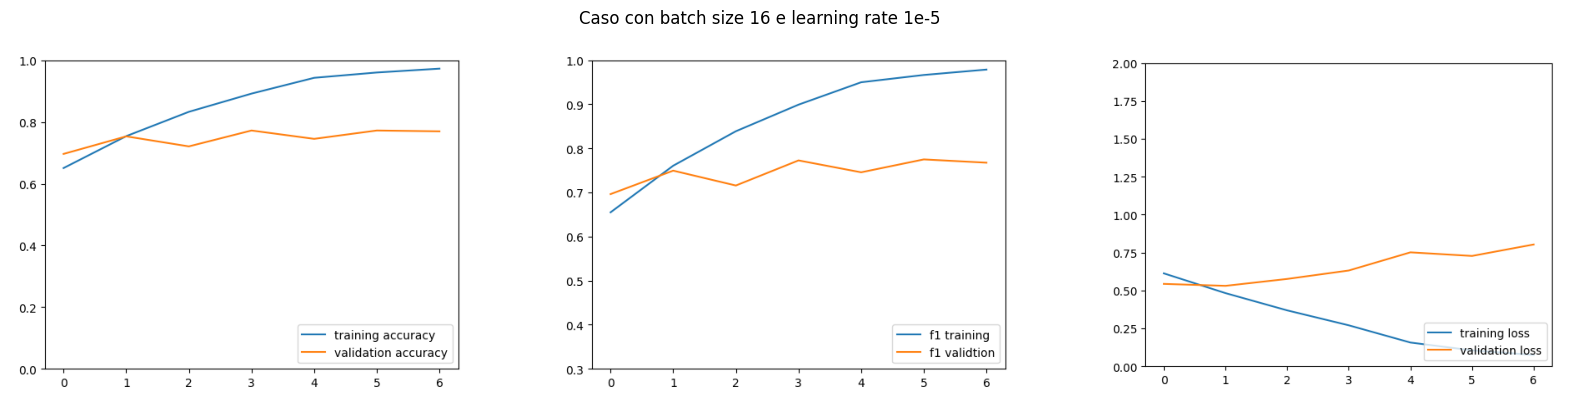

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


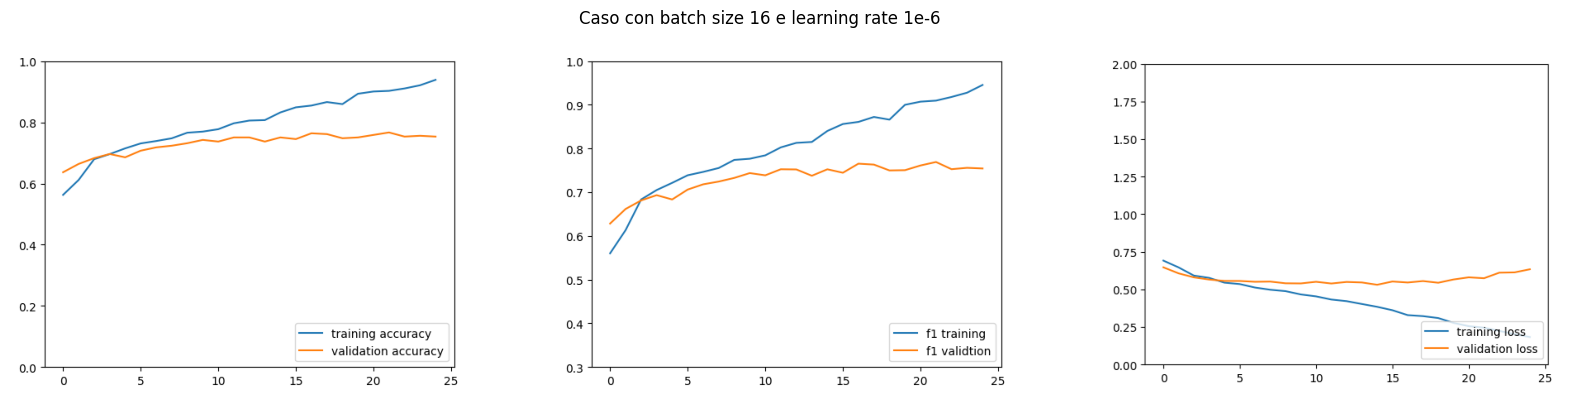

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


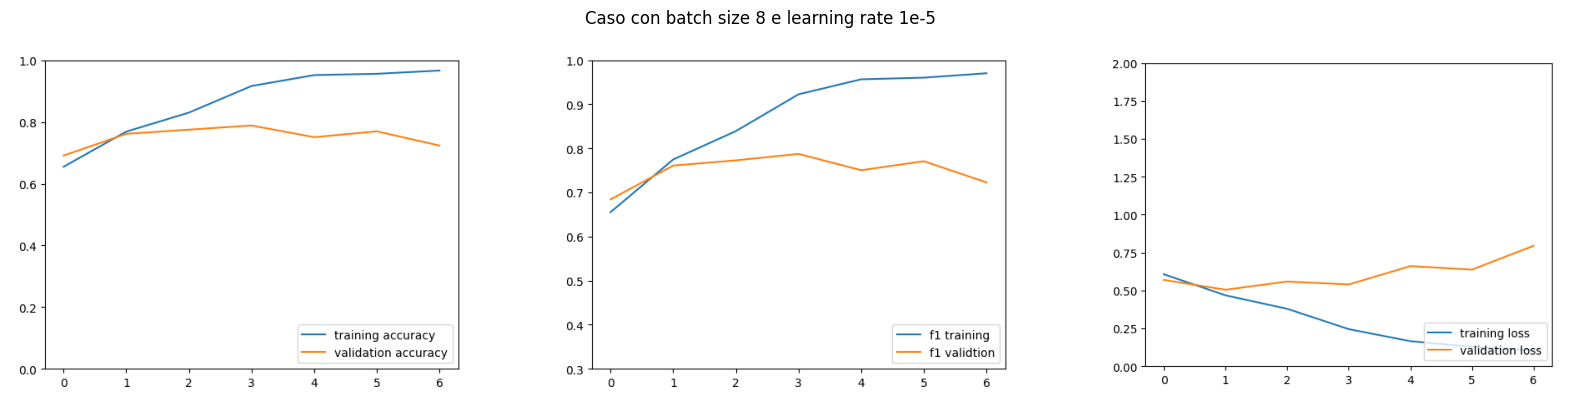

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


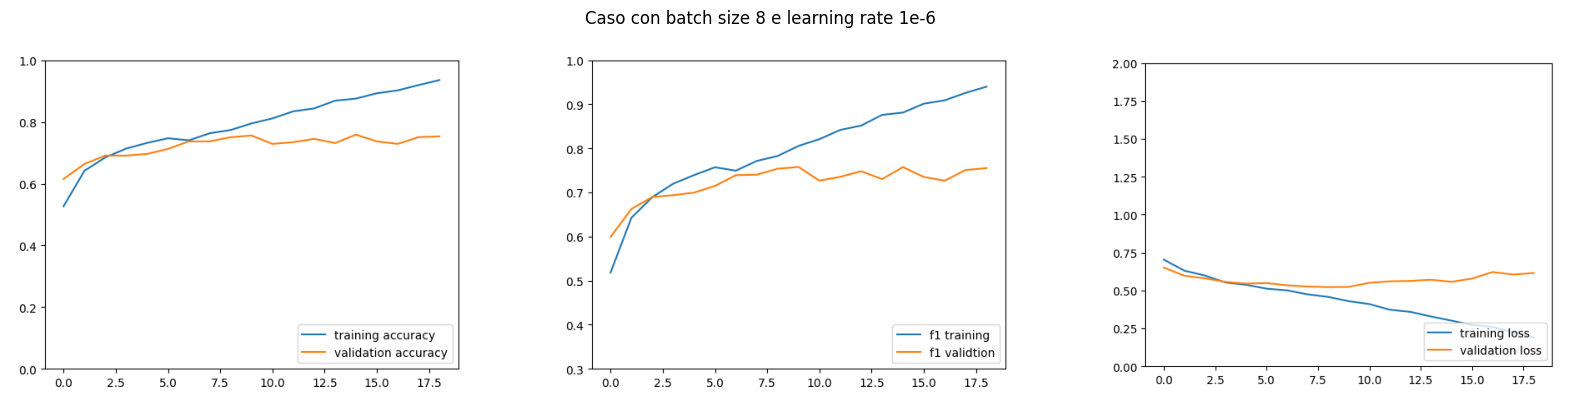

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
folder = '/content/gdrive/MyDrive/Tris di token/Bert_Multilingua_Plot/Subtask A'

# Lista dei titoli delle sottocartelle
titoli_sottocartelle = ['batch size 16 e learning rate 1e-5', 'batch size 16 e learning rate 1e-6', 'batch size 8 e learning rate 1e-5', 'batch size 8 e learning rate 1e-6']

# Per ogni sottocartella
for titolo_sottocartella in titoli_sottocartelle:

    # Percorso completo della sottocartella
    percorso_sottocartella = os.path.join(folder, titolo_sottocartella)

    # Lista dei file nella sottocartella
    file_immagini = [f for f in os.listdir(percorso_sottocartella) if f.endswith('.png')]

    plt.figure(figsize=(20,6))

    for i, image in enumerate(file_immagini):

      img = mpimg.imread(os.path.join(percorso_sottocartella, image))

      plt.suptitle('Caso con ' + titolo_sottocartella, y=0.85)
      plt.subplot(1, 3, i+1)
      plt.imshow(img)

      plt.axis('off')

    plt.show()
    print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')



Risultati dell'addestramento alla migliore epoca:

In [ ]:
bert_multilingua_risultati=pd.read_csv(root+"bert_multilingua_risultatiA.csv",delimiter=";")
bert_multilingua_risultati

,Iperparametri,loss,accuracy,f1
0,bs: 16 lr:1e-5,0.5307,0.7534,0.7496
1,bs: 8 lr:1e-5,0.5050,0.7615,0.7615
2,bs: 16 lr:1e-6,0.5308,0.7507,0.7525
3,bs: 8 lr:1e-6,0.5224,0.7507,0.7540


Per quanto riguarda la performance di Bert Multilingua per  il task A notiamo che in ogni caso abbiamo evitato l'overfitting attraverso l'earlystopping ed il layer di batch normalization arrivando difatti ad una convergenza dei pesi del modello già alle prime epoche nei casi con learning rate pari ad 1e-5.  
La rete quindi  ottiene un buon risultato, valutandola sul  validation set, usando  una dimensione del batch pari ad 8 ed un learning rate pari ad 1e-5 addirittura già alla seconda epoca di addestramento come possiamo vedere dai plot soprastanti;
sicuramente la validation loss sarebbe preferibile abbassarla ulteriormente dato che si mantiene su un valore appena accettabile ,diversamente si può notare che  l'f1 score  ottenuto è un valore discretamente buono , che permette una discriminazione tra testi cospiratori e non cospiratori  accettabile.

##Roberta Model

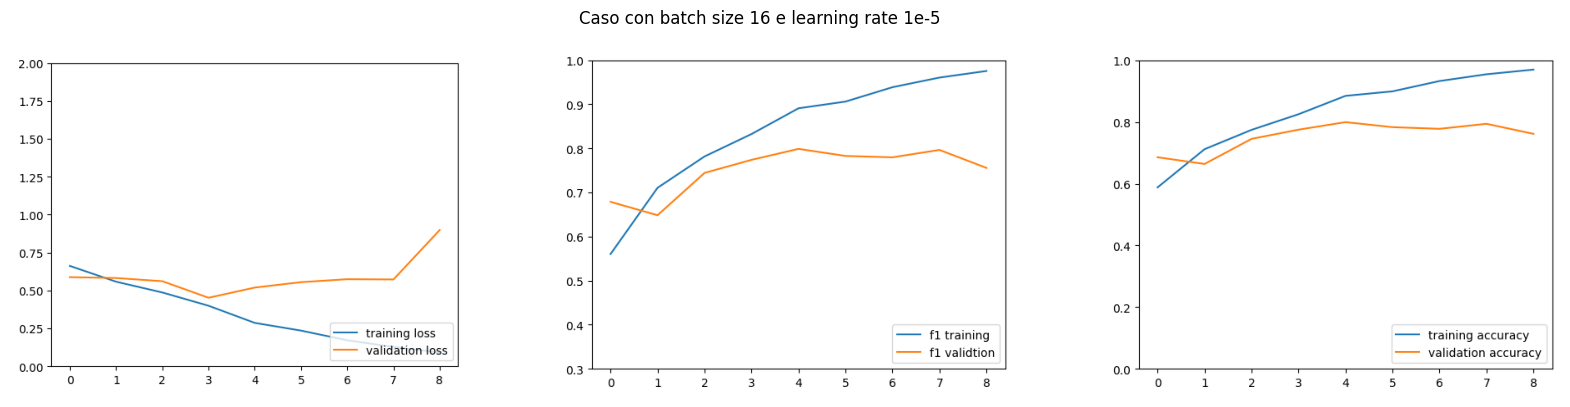

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


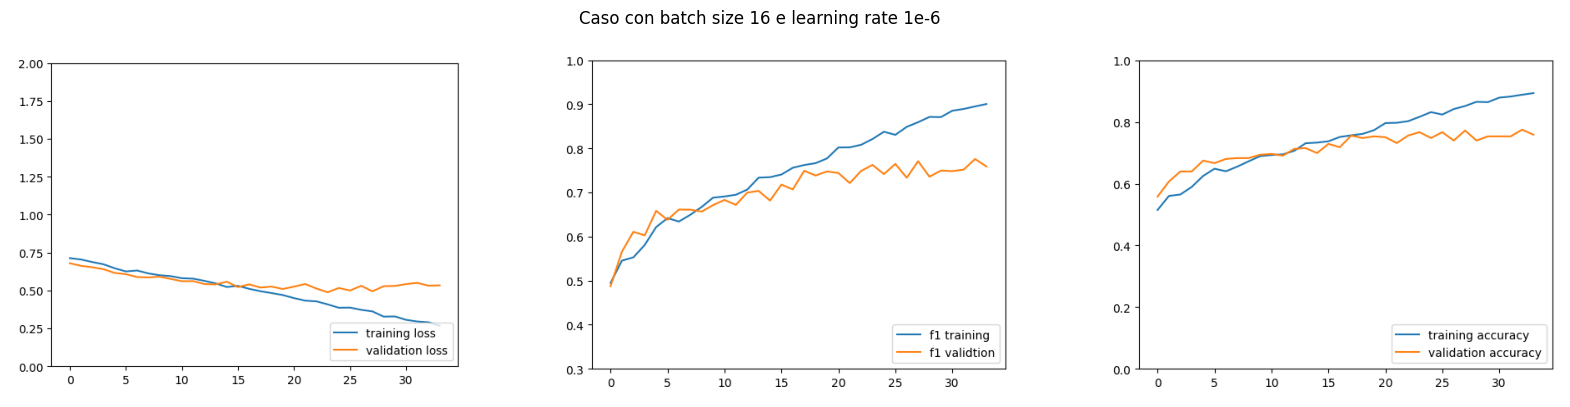

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


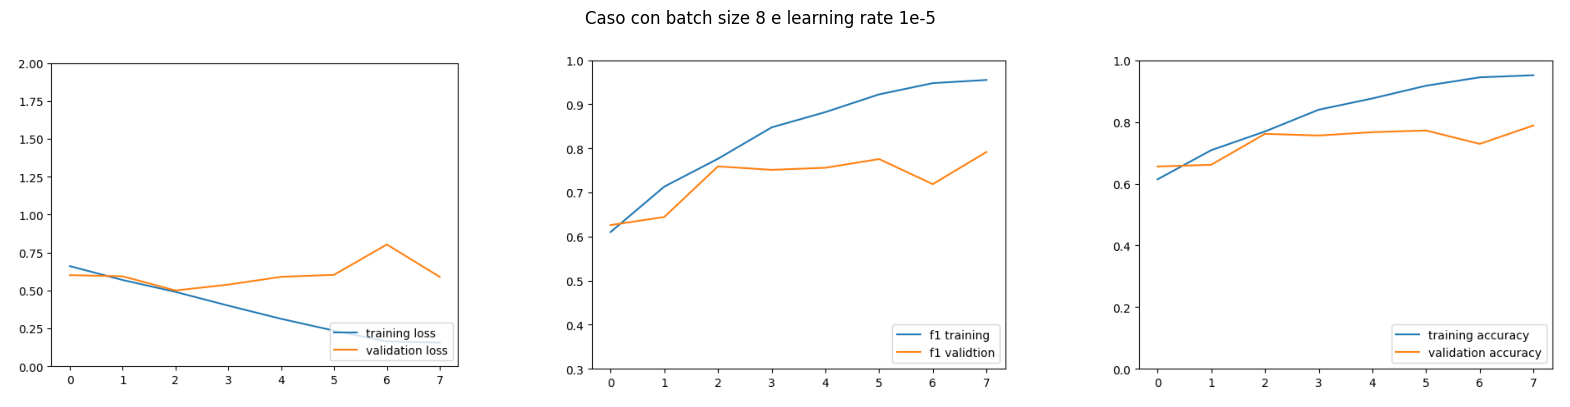

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


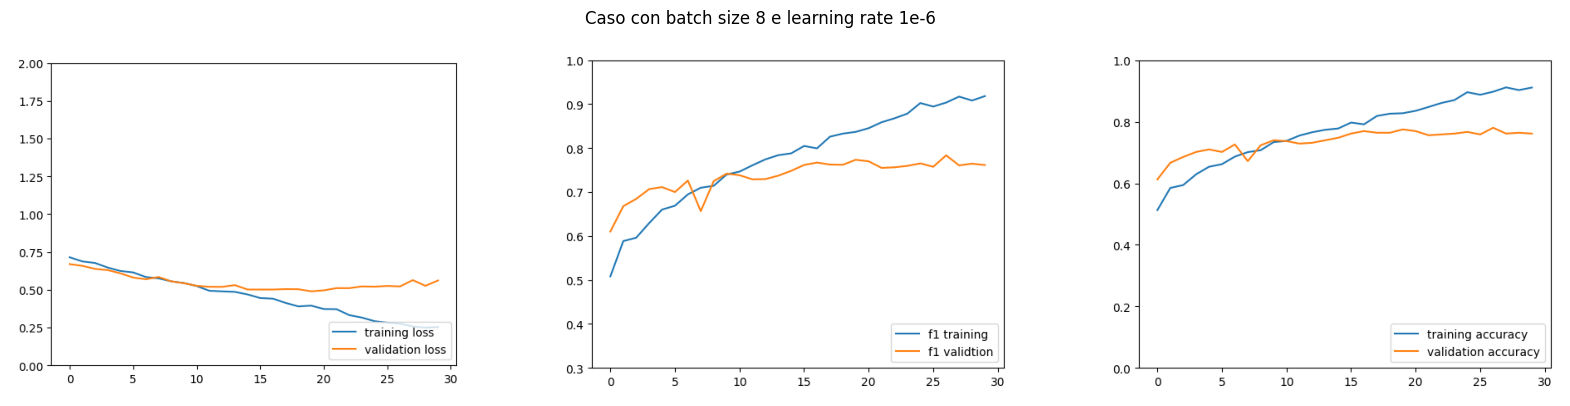

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
folder = '/content/gdrive/MyDrive/Tris di token/Roberta_Plot/Subtask A'

# Lista dei titoli delle sottocartelle
titoli_sottocartelle = ['batch size 16 e learning rate 1e-5', 'batch size 16 e learning rate 1e-6', 'batch size 8 e learning rate 1e-5', 'batch size 8 e learning rate 1e-6']

# Per ogni sottocartella
for titolo_sottocartella in titoli_sottocartelle:

    # Percorso completo della sottocartella
    percorso_sottocartella = os.path.join(folder, titolo_sottocartella)

    # Lista dei file nella sottocartella
    file_immagini = [f for f in os.listdir(percorso_sottocartella) if f.endswith('.png')]

    plt.figure(figsize=(20,6))

    for i, image in enumerate(file_immagini):

      img = mpimg.imread(os.path.join(percorso_sottocartella, image))

      plt.suptitle('Caso con ' + titolo_sottocartella, y=0.85)
      plt.subplot(1, 3, i+1)
      plt.imshow(img)

      plt.axis('off')

    plt.show()
    print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

Risultati dell'addestramento alla migliore epoca:

In [ ]:
roberta_risultati=pd.read_csv(root+"roberta_risultatiA.csv",delimiter=";")
roberta_risultati

,Iperparametri,loss,accuracy,f1
0,bs: 16 lr:1e-5,0.4522,0.7751,0.7741
1,bs: 8 lr:1e-5,0.5006,0.7615,0.7592
2,bs: 16 lr:1e-6,0.4884,0.7669,0.7626
3,bs: 8 lr:1e-6,0.4898,0.7751,0.7735


Per quanto riguarda le performance di Roberta per il subtask A abbiamo notato dei risultati in termini di accuracy e f1-score migliori, anche se non di tanto, rispetto agli altri due modelli utilizzati. Anche in questo caso abbiamo evitato l'overfitting tramite EarlyStopping ed il layer di dropout arrivando così ad una convergenza dei pesi del modello sin dalle prime epoche nei casi in cui avevamo learning rate pari ad 1e-5. La rete ottiene il miglior risultato, considerandola sulla validation loss, usando una dimensione del batch pari ad 16 ed un learning rate pari ad 1e-5 addirittura già alla terza epoca di addestramento come possiamo vedere dal plot appropriato. Abbiamo notato inoltre che, in questo particolare modello, la rete migliora le performance lasciando le emoji non tradotte.

##Italian Bert Model

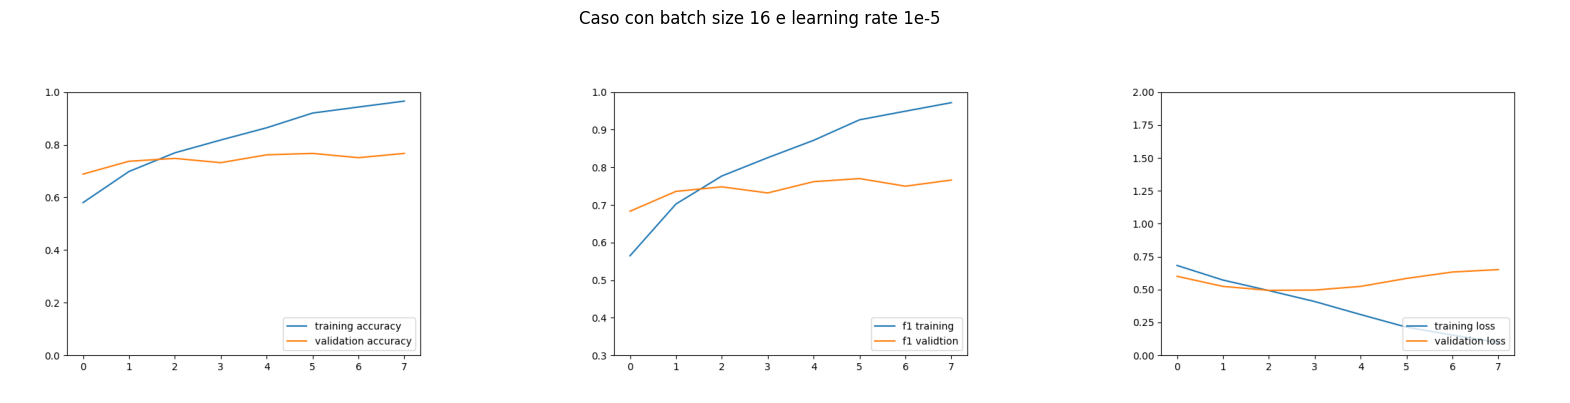

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


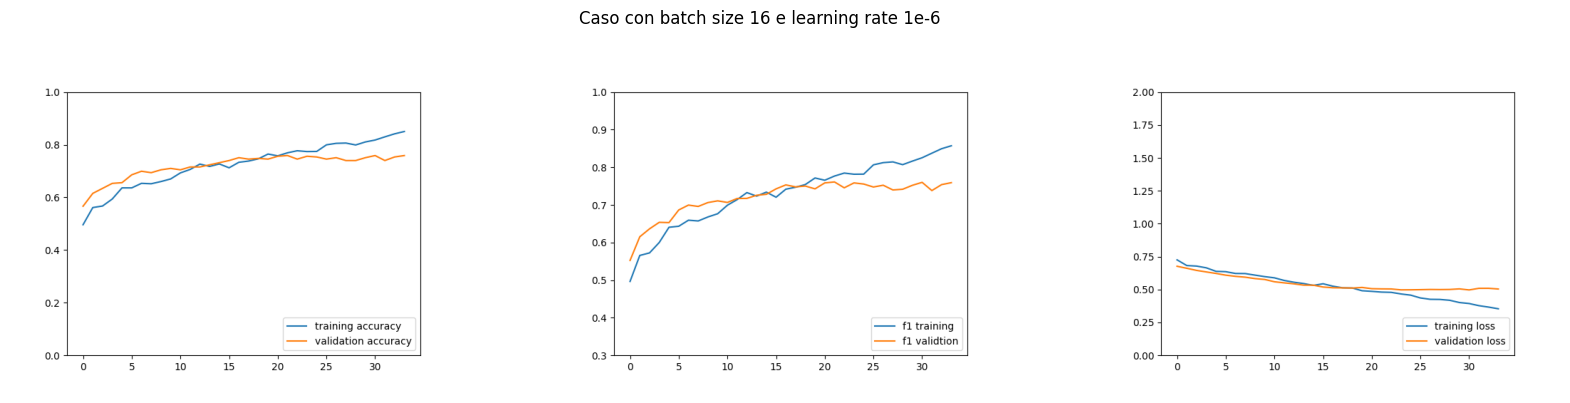

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


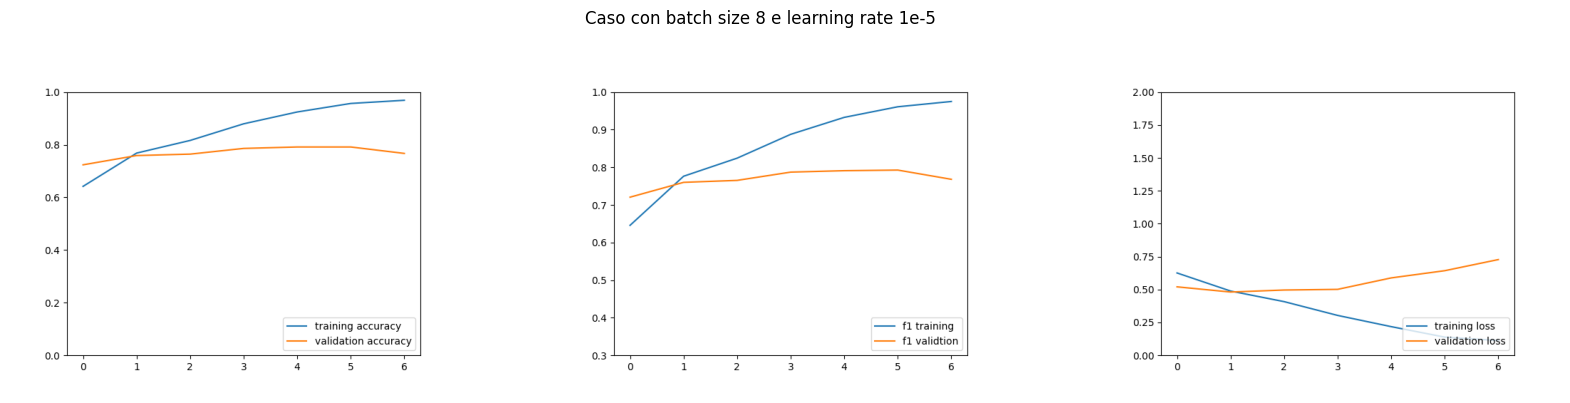

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


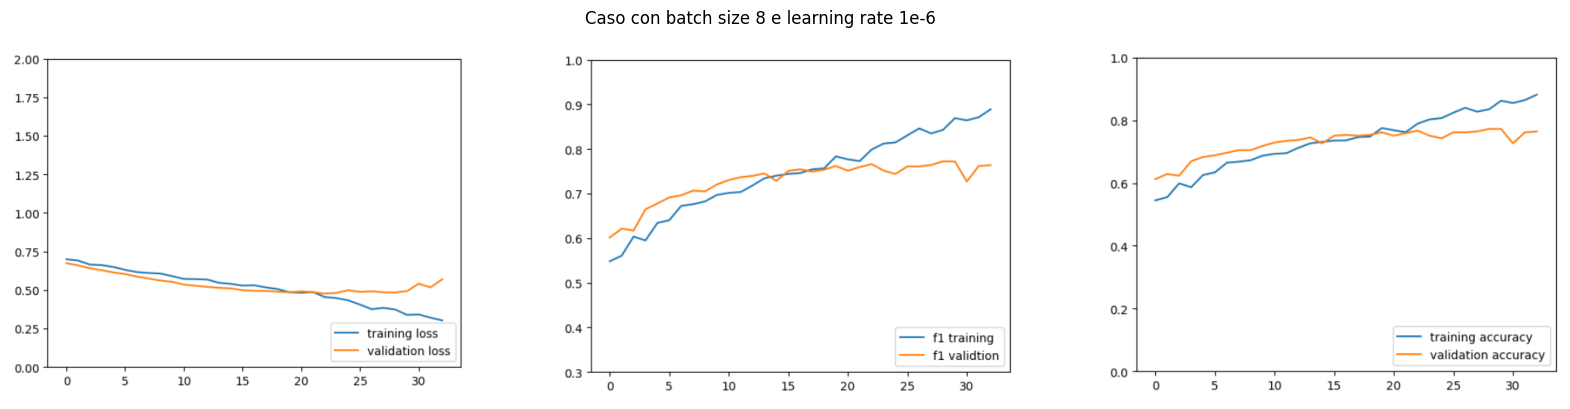

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
folder = '/content/gdrive/MyDrive/Tris di token/Italian_Bert_Plot/Subtask A'

# Lista dei titoli delle sottocartelle
titoli_sottocartelle = ['batch size 16 e learning rate 1e-5', 'batch size 16 e learning rate 1e-6', 'batch size 8 e learning rate 1e-5', 'batch size 8 e learning rate 1e-6']

# Per ogni sottocartella
for titolo_sottocartella in titoli_sottocartelle:

    # Percorso completo della sottocartella
    percorso_sottocartella = os.path.join(folder, titolo_sottocartella)

    # Lista dei file nella sottocartella
    file_immagini = [f for f in os.listdir(percorso_sottocartella) if f.endswith('.png')]

    plt.figure(figsize=(20,6))

    for i, image in enumerate(file_immagini):

      img = mpimg.imread(os.path.join(percorso_sottocartella, image))

      plt.suptitle('Caso con ' + titolo_sottocartella, y=0.85)
      plt.subplot(1, 3, i+1)
      plt.imshow(img)

      plt.axis('off')

    plt.show()
    print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

Risultati dell'addestramento alla migliore epoca:

In [ ]:
italian_bert_risultati=pd.read_csv(root+"italian_bert_risultatiA.csv",delimiter=";")
italian_bert_risultati

,Iperparametri,loss,accuracy,f1
0,bs: 16 lr:1e-5,0.4938,0.7480,0.7480
1,bs: 8 lr:1e-5,0.4811,0.7588,0.7599
2,bs: 16 lr:1e-6,0.4970,0.7588,0.7600
3,bs: 8 lr:1e-6,0.4768,0.7669,0.7665


Analizzando i risultati di Italian Bert possiamo notare che abbiamo ottenuto valori comparabili per tutte le quattro combinazioni di iperparametri ma la migliore risulta quella con batch size 8 e learning rate 1e-5, che comunque risulta sempre minore rispetto ai risultati ottenuti con gli altri due modelli.

# Submission

Per effettuare le submissions abbiamo scelto di provare la combinazione di iperparametri che ha performato meglio per ogni modello ottenendo i seguenti risultati:

In [ ]:
submission=pd.read_csv(root+"submissions_A_risultati.csv",delimiter=";")
submission

,Modello,Private Score,Public Score
0,Bert Multilingua bs: 8 lr:1e-5,0.79066,0.75624
1,Italiab Bert bs:8 lr:1e-6,0.76566,0.73863
2,Roberta bs:16 lr:1e-5,0.74049,0.75279


Dai risultati ottenuti possiamo notare che il miglior modello è stato Bert Multilingua con batch size 8 e learning rate 1e-5, con un punteggio di 0.79066  
Come ulteriore prova abbiamo provato quest'ultimo modello senza l'analisi delle emoji e abbiamo ottenuto uno score di 0.78852 che risulta comunque migliore dei risultati ottenuti dagli altri due modelli ma peggiore rispetto a quello con preprocessing.